# Calculate how everything combined impacts wRC+
Stats: Age, wRC+, EV, LA, Barrel%, HardHit%, BABIP, LD%, GB%, FB%, IFFB%, Pull%, Cent%, Oppo%, OBP, SLG, BB%, K%

In [12]:
import utils
import pandas as pd
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [13]:
# load data
data = pd.read_csv('full_data.csv')

In [14]:
# get subsets of data
X = pd.DataFrame({ 'Age': [], 'wRC+': [], 'EV': [], 'LA': [], 'Barrel%': [], 'HardHit%': [], 'BABIP': [], 'LD%': [], 
                  'GB%': [], 'FB%': [], 'IFFB%': [], 'Pull%': [], 'Cent%': [], 'Oppo%': [], 'OBP': [], 'SLG': [],
                  'BB%': [], 'K%': []})
y = pd.DataFrame({'wRC+': []})

# iterate through data and connect ages and wRC+ to the following season's wRC+
for index, row in data.iterrows():
    next_year = data.loc[(data['PlayerId'] == row['PlayerId']) & (data['Season'] == row['Season'] + 1)]

    if next_year.size > 0:

        to_add_x = pd.DataFrame({
            'Age': [row['Age']],
            'wRC+': [row['wRC+']],
            'EV': [row['EV']],
            'LA': [row['LA']],
            'Barrel%': [row['Barrel%']],
            'HardHit%': [row['HardHit%']],
            'BABIP': [row['BABIP']],
            'LD%': [row['LD%']],
            'GB%': [row['GB%']],
            'FB%': [row['FB%']],
            'IFFB%': [row['IFFB%']],
            'Pull%': [row['Pull%']],
            'Cent%': [row['Cent%']],
            'Oppo%': [row['Oppo%']],
            'OBP': [row['OBP']],
            'SLG': [row['SLG']],
            'BB%': [row['BB%']],
            'K%': [row['K%']]})
        X = pd.concat([X, to_add_x], ignore_index=True)

        to_add_y = pd.DataFrame({'wRC+': next_year['wRC+']})
        y = pd.concat([y, to_add_y], ignore_index=True)

# scale X
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X))

In [15]:
# display shape of data
print('Shape of X:', X.shape)
print('Shape of y:', y.shape)

Shape of X: (1662, 18)
Shape of y: (1662, 1)


In [16]:
# separate into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=7)

# convert train sets to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

# convert test sets to tensors
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [17]:
# set batch size
batch_size = 32

# create datasets
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

# create dataloaders
train_loader = DataLoader(train_data, batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size, shuffle=False)

for X, y in test_loader:
    print(f"Shape of X: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X: torch.Size([32, 18])
Shape of y: torch.Size([32, 1]) torch.float32


In [18]:
# get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [19]:
# define model
model = utils.RegressionModel(X.shape[1]).to(device)
print(model)

RegressionModel(
  (layer1): Linear(in_features=18, out_features=36, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=36, out_features=36, bias=True)
  (relu2): ReLU()
  (layer3): Linear(in_features=36, out_features=1, bias=True)
)


In [20]:
# define loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = .001)

Epoch 1
-------------------------------
Batch 1, Loss: 10950.6895
Batch 6, Loss: 9659.0303
Batch 11, Loss: 12455.8408
Batch 16, Loss: 11954.7363
Batch 21, Loss: 12218.2871
Batch 26, Loss: 10650.7686
Batch 31, Loss: 10403.3340
Batch 36, Loss: 10919.9014
Batch 41, Loss: 11101.3711
Average loss: 11359.583680555555
tensor([[2.5782],
        [1.9533],
        [1.0466],
        [1.2733],
        [2.2578],
        [2.1879],
        [2.0743],
        [1.4832],
        [1.3915],
        [2.7068],
        [1.3988],
        [1.6768],
        [0.8415],
        [3.7337],
        [2.6467],
        [1.3661],
        [2.8971],
        [2.0086],
        [1.1022],
        [2.6054],
        [2.6624],
        [1.0510],
        [1.6485],
        [1.7258],
        [1.6025],
        [2.3737],
        [1.5473],
        [1.3776],
        [1.5874],
        [2.0316],
        [2.4734],
        [1.2855]])
tensor([[1.4666],
        [1.4030],
        [1.9924],
        [1.4450],
        [1.9774],
        [1.2598],
  

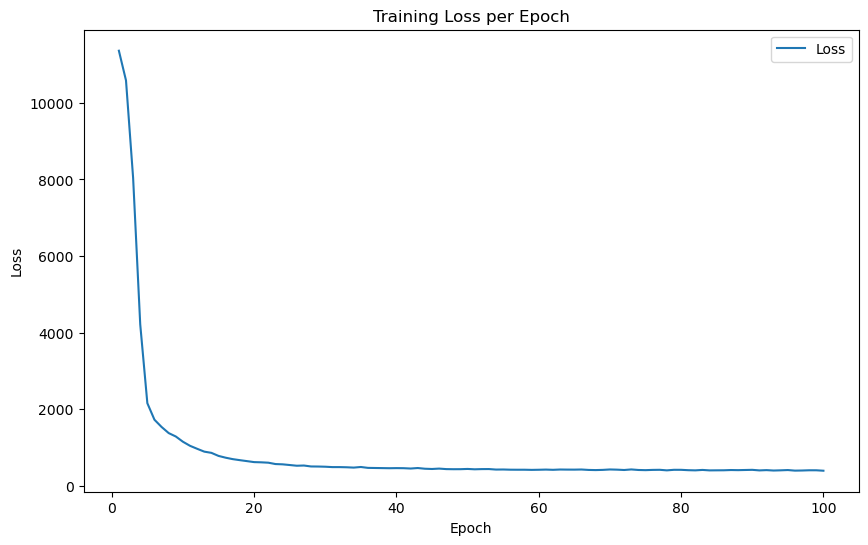

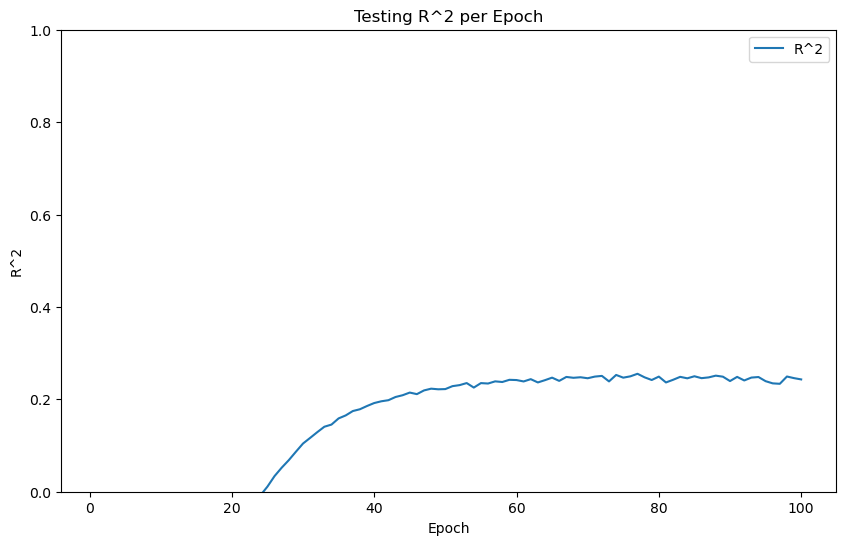

In [21]:
# run model
utils.run_model(100, train_loader, test_loader, model, loss_fn, optimizer, device)

In [22]:
# save model
torch.save(model.state_dict(), "models/model_4.pth")
print("Saved PyTorch Model State to 'model_4.pth' in 'models' folder")

Saved PyTorch Model State to 'model_4.pth' in 'models' folder
